## Artificial vortex array flow test

## Averaged flows


In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
import pickle 
import os
import sys

sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder

def analyze_defects(img, sigma=15):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, sigma)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf

%matplotlib qt

import sys,time,random
def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()


image_list = glob.glob(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

### Test flow parameters
`flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)`

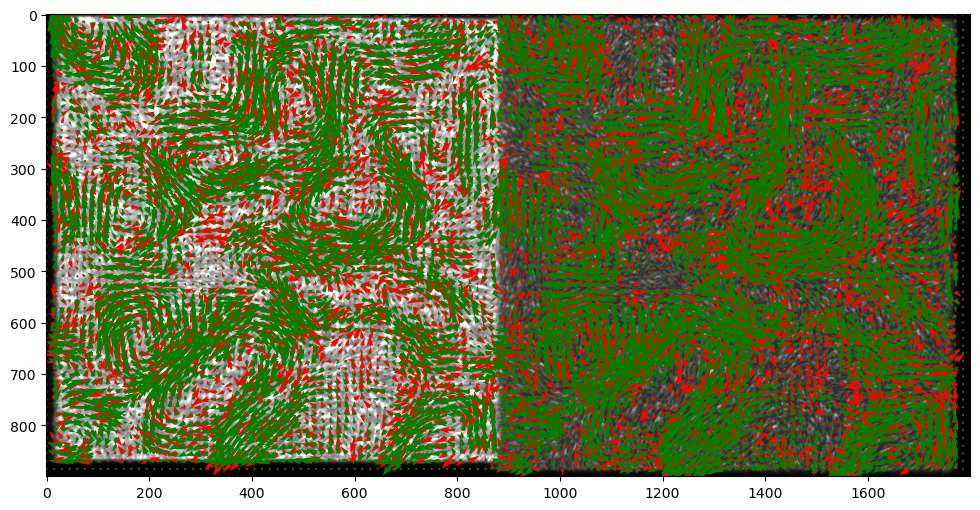

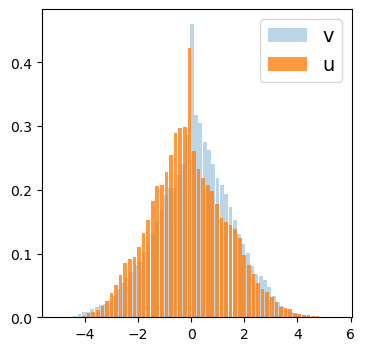

In [2]:
%matplotlib inline
skip = 1
n = 10 * skip

u = np.zeros_like(cv2.imread(image_list[0])[:,:,0], dtype=np.float32)
v = np.zeros_like(u)

for (i,im1), im2 in zip(enumerate(image_list[:n:skip]), image_list[1:n+1:skip]):

    img1 = cv2.imread(im1)[:,:,0]
    img2 = cv2.imread(im2)[:,:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0) 
    u += flow[..., 0]
    v += flow[..., 1]

step = 15
fig, ax1 = plt.subplots(1,1,  figsize=(12,6))
ax1.imshow(img1, cmap="gray")

x = np.arange(0, flow.shape[1], step, dtype=np.int16)
y = np.arange(0, flow.shape[0], step, dtype=np.int16)
ax1.quiver(x,y, 
        flow[::step, ::step, 0], -flow[::step, ::step, 1], 
        color="red", scale=150)
ax1.quiver(x,y, 
        u[::step, ::step]/(i+1), -v[::step, ::step]/(i+1), 
        color="green", scale=150)

fig, ax2 = plt.subplots(1,1,  figsize=(4,4))
ax2.hist(np.concatenate(v)/(i+1), 60, alpha=.3, rwidth=.9, density=True, label="v")
ax2.hist(np.concatenate(u)/(i+1),60, alpha=.8, rwidth=.8, density=True, label="u")
plt.legend(loc='upper right', fontsize=14)

In [44]:
%matplotlib inline
SAVE = True
PLOT = False
CHECK  = False

for (i,im1), im2 in zip(enumerate(image_list[:-1]), image_list[1:]):
    #right image [:,900:,0] / left image [:,:900,0]
    img1 = cv2.imread(im1)[:,900:,0]
    img2 = cv2.imread(im2)[:,900:,0]
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    save_path = os.path.join(
        os.path.dirname(image_list[i]), 
        'OptFlow', 
        os.path.splitext(os.path.basename(image_list[i]))[0] + '_u_v.pkl'
        )
    step = 15   

    if PLOT:
        fig = plt.figure(figsize=(10,10))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        plt.imshow(255-img_clahe, cmap="gray")

        x = np.arange(0, flow.shape[1], step, dtype=np.int16)
        y = np.arange(0, flow.shape[0], step, dtype=np.int16)
        plt.quiver(x,y, 
                flow[::step, ::step, 0], -flow[::step, ::step, 1], 
                color="red", scale=150, label="flow")
    
    if SAVE:  
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        scale = 3
        with open(save_path, 'wb') as f:
                pickle.dump(dict(u=flow[::scale,::scale,0], v=flow[::scale,::scale,1], scale=scale), f)
    
    if CHECK:
        with open(save_path, 'rb') as f:
            loaded_dict = pickle.load(f)  

        sstep = step//loaded_dict["scale"]
        plt.quiver(x, y,
                loaded_dict["u"][::sstep, ::sstep], -loaded_dict["v"][::sstep, ::sstep], 
                color="green", scale=200, label="dict")
    
    # break

    
    progressBar(i, len(image_list))
plt.legend(loc='upper right', fontsize=14)

In [43]:
%matplotlib inline
PLOT = False
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

for i,im1 in enumerate(image_list[:]):
    img1 = cv2.imread(im1)[:,900:,0]
    ori, plushalf, minushalf = analyze_defects(img1, sigma=11)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("_X")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)

    if PLOT:
        fig, ax = plt.subplots(1,1, figsize=(10,10))

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(img_clahe, cmap="gray")

        s = 15
        x = np.arange(0, img1.shape[1], s)
        y = np.arange(0, img1.shape[0], s)

        ax.quiver(x,y, #xx[::s,::s], yy[::s,::s],
            np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='lawngreen', scale=60, pivot='mid', alpha=.5)

        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for i in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        break

    if not i %50:  
        save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        minushalf_df.to_csv(save_path)
        save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
        plushalf_df.to_csv(save_path)

    save_path = os.path.join(
            os.path.dirname(im1), 
            'Nematic', 
            os.path.splitext(os.path.basename(im1))[0]
            )
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    cv2.imwrite(save_path + '_orient.tif', ori)
    # break

    progressBar(i, len(image_list))